# KNN, Gaussian Naive Bayes and Data Analysis (with Tableau)

## Online News Popularity dataset

In [35]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV, cross_val_score
from sklearn.naive_bayes import GaussianNB, MultinomialNB
from sklearn.metrics import roc_auc_score
import matplotlib.pyplot as plt


In [36]:
data = pd.read_csv('./OnlineNewsPopularity/OnlineNewsPopularity.csv', header = 0)


## Data preprocessing

In [37]:
for i in range(len(data.columns)):
    data.columns.values[i] = data.columns.values[i].replace(" ", "")
    
X = data.iloc[:, 2:-1]
y = data.iloc[:, -1]

X_train, X_test, y_train_old, y_test_old = train_test_split(X, y, test_size=0.2, random_state=21)
X_train.reset_index(drop = True, inplace = True)
X_test.reset_index(drop = True, inplace = True)
y_train_old.reset_index(drop = True, inplace = True)
y_test_old.reset_index(drop = True, inplace = True)

### Binary Classification

Our target variable `shares` is a numeric quantity, since we are working with a classification problem, we encode our target variable as a boolean - popular or non-popular. For that we find the median of the shares and use that to classify our training data. 


In [38]:
shares_median = np.median(y_train_old)
shares_median

1400.0

In [39]:
y_train = y_train_old.copy()
y_test = y_test_old.copy()

for i in range(y_train_old.shape[0]):
    if y_train_old[i] < shares_median:
        y_train[i] = 0
    else:
        y_train[i] = 1
      
for i in range(y_test_old.shape[0]):
    if y_test_old[i] < shares_median:
        y_test[i] = 0
    else:
        y_test[i] = 1

## K-Nearest Neighbor

Using sklearn's KNeighborsClassifier we are going to find the accuracy for different values of k and then select k with max accuracy. 

In [47]:
neighbors = np.arange(10, 250, 50)
train_acc = []
test_acc = []

for k in neighbors:
    knn = KNeighborsClassifier(n_neighbors=k)
    knn.fit(X_train, y_train)
    train_acc.append(knn.score(X_train, y_train))
    test_acc.append(knn.score(X_test, y_test))

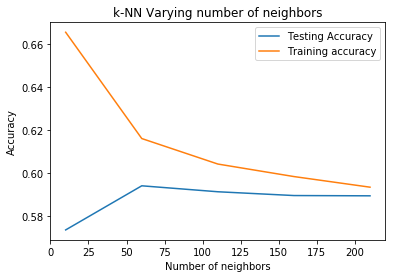

In [48]:
plt.title('k-NN Varying number of neighbors')
plt.plot(neighbors, test_acc, label='Test Accuracy')
plt.plot(neighbors, train_acc, label='Train accuracy')
plt.legend()
plt.xlabel('Number of neighbors')
plt.ylabel('Accuracy')
plt.show()

We can see that the maximum test accuracy is received by k in the range of 60-70. Let's check the range near this and try to find a more accurate value. 

In [50]:
neighbors = np.arange(60, 70)
train_acc = []
test_acc = []

for k in neighbors:
    knn = KNeighborsClassifier(n_neighbors=k)
    knn.fit(X_train, y_train)
    train_acc.append(knn.score(X_train, y_train))
    test_acc.append(knn.score(X_test, y_test))

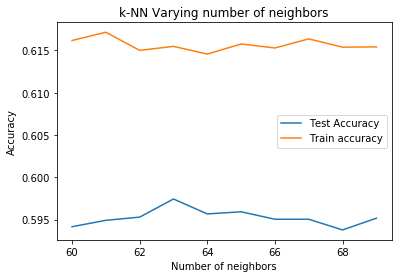

In [51]:
plt.title('k-NN Varying number of neighbors')
plt.plot(neighbors, test_acc, label='Test Accuracy')
plt.plot(neighbors, train_acc, label='Train accuracy')
plt.legend()
plt.xlabel('Number of neighbors')
plt.ylabel('Accuracy')
plt.show()

It's clear that 63 nearest neighbors gives us the best test accuracy. Let's fit our model to this value. 

In [52]:
knn = KNeighborsClassifier(n_neighbors=63)
knn.fit(X_train, y_train)
knn.score(X_test, y_test)

0.5974271660991298

Our model achieves an accuracy of 59%.

In [55]:
# roc score
y_pred = knn.predict_proba(X_test)[:,1]
knn.score(X_test, y_test)
metrics.roc_auc_score(y_test,y_pred)

0.6265579606065822

And the AUC score is 0.62645 which is the best performance.

## Gaussian Naive Bayes

In [58]:
clf_gnb = GaussianNB().fit(X_train, y_train)
y_pred = clf_gnb.predict(X_test)
print('Accuracy: ', clf_gnb.score(X_test, y_test))
print('AUC: ', metrics.roc_auc_score(y_test,y_pred))

Accuracy:  0.5056123092445454
AUC:  0.5335804352123696


## Data Processing for Visualizations

In order to visualize our data with Tableau and get some insights, we need to modify our data since the values in our dataset are one-hot encoded.

#### Categorize Weekday

In [5]:
for i, row in data.iterrows():
    day_name = None
    for day in ['weekday_is_monday', 'weekday_is_tuesday', 'weekday_is_wednesday', 'weekday_is_thursday', 'weekday_is_friday', 'weekday_is_saturday', 'weekday_is_sunday']:
        if row[day] == 1:
            day_name = day.split('_')[-1]
            break
    data.at[i, 'day'] = day_name

In [6]:
data['day'].unique()

array(['monday', 'tuesday', 'wednesday', 'thursday', 'friday', 'saturday',
       'sunday'], dtype=object)

#### Categorize Data Channel

In [7]:
for i, row in data.iterrows():
    channel_name = 'other'
    for channel in ['data_channel_is_lifestyle',
       'data_channel_is_entertainment', 'data_channel_is_bus',
       'data_channel_is_socmed', 'data_channel_is_tech',
       'data_channel_is_world']:
        if row[channel] == 1:
            channel_name = channel.split('_')[-1]
            if channel_name == 'bus':
                channel_name = 'business'
            elif channel_name == 'socmed':
                channel_name = 'social media'
            break
    data.at[i, 'data_channel'] = channel_name

In [8]:
data['data_channel'].unique()

array(['entertainment', 'business', 'tech', 'lifestyle', 'world', 'other',
       'social media'], dtype=object)

In [9]:
data.to_csv(path_or_buf='./online_news_with_day_channel_category.csv')